Install dependencies

In [180]:
!pip install mysql-connector-python pandas scikit-learn ydata-profiling matplotlib seaborn catboost
%matplotlib inline

In [181]:
import pandas as pd
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import numpy as np

MySQL Database Connection

In [182]:
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'PKK65QSteam'
}
conn = mysql.connector.connect(**db_config)

dim_game = pd.read_sql("SELECT * FROM dim_game", conn)
fact_metrics = pd.read_sql("SELECT * FROM fact_game_metrics", conn)

df = pd.merge(dim_game, fact_metrics, on='AppID')

C:\Users\gyoni\AppData\Local\Temp\ipykernel_2580\1426311818.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_game = pd.read_sql("SELECT * FROM dim_game", conn)
C:\Users\gyoni\AppData\Local\Temp\ipykernel_2580\1426311818.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_metrics = pd.read_sql("SELECT * FROM fact_game_metrics", conn)


Drop cells that can't be used for prediction

In [183]:
drop_columns = [
    'Peak_CCU', 'Positive', 'Negative',
    'Recommendations', 'steamspy_positive', 'steamspy_negative',
    'Header_image', 'Estimated_owners', 'Discount'
]
df.drop(columns=drop_columns, inplace=True)
df = df[df['Estimated_Revenue'].notnull()]

Run profiling

In [184]:
profile = ProfileReport(df, title="Game Dataset Profiling Report", explorative=True, minimal=True)
profile.to_file("PKK65Q_BI_HW_Profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:02<00:00,  8.18it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Convert boolean OS support columns to integers

In [185]:
df['Windows'] = df['Windows'].astype(int)
df['Mac'] = df['Mac'].astype(int)
df['Linux'] = df['Linux'].astype(int)

Drop string/date columns

In [186]:
df.drop(columns=['Name', 'Genres', 'Tags', 'Categories', 'Release_date'], inplace=True)

Split dataset into train and validation sets

In [187]:
X = df.drop(columns=['AppID', 'Estimated_Revenue'])
for col in ['Price', 'DLC_count', 'Achievements', 'Median_playtime_forever']:
    if col in X.columns:
        X[col] = np.log1p(X[col])

y = df['Estimated_Revenue']
y = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

Train CatBoost model

In [188]:
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.01,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    od_type='Iter',
    early_stopping_rounds=100,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val = np.expm1(y_val)

print("MSE:", mean_squared_error(y_val, y_pred))

0:	learn: 2.3362627	test: 2.2981804	best: 2.2981804 (0)	total: 5.21ms	remaining: 15.6s
100:	learn: 1.7900446	test: 1.7561628	best: 1.7561628 (100)	total: 458ms	remaining: 13.1s
200:	learn: 1.6749057	test: 1.6467280	best: 1.6467280 (200)	total: 905ms	remaining: 12.6s
300:	learn: 1.6460855	test: 1.6214129	best: 1.6214129 (300)	total: 1.34s	remaining: 12s
400:	learn: 1.6352805	test: 1.6127177	best: 1.6127177 (400)	total: 1.78s	remaining: 11.6s
500:	learn: 1.6291923	test: 1.6084814	best: 1.6084814 (500)	total: 2.23s	remaining: 11.1s
600:	learn: 1.6250899	test: 1.6057371	best: 1.6057371 (600)	total: 2.69s	remaining: 10.7s
700:	learn: 1.6215178	test: 1.6033877	best: 1.6033877 (700)	total: 3.15s	remaining: 10.3s
800:	learn: 1.6181944	test: 1.6015510	best: 1.6015510 (800)	total: 3.61s	remaining: 9.92s
900:	learn: 1.6149279	test: 1.5995018	best: 1.5995016 (899)	total: 4.08s	remaining: 9.5s
1000:	learn: 1.6119003	test: 1.5976636	best: 1.5976636 (1000)	total: 4.54s	remaining: 9.07s
1100:	learn: 1

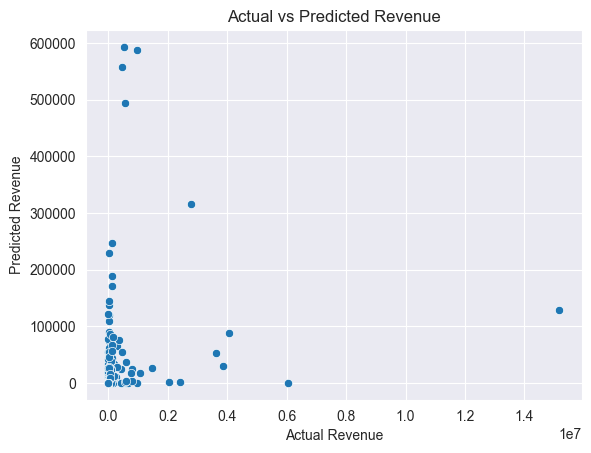

In [190]:
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()